First let's import tensorflow, padding and the Tokenizer. Then specify our hyper parameters; the vocabulary size, embedding dimensions, maximum length of sentences, and other stuff like the training size. The sarcasm dataset is available at the url, can be downoladed as a Json file using `urllib` library. The sarcasm dataset contains more than 27000 records so we will divided into 20000 for training and 7000 for testing.

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

vocab_size = 10000
embeddin_dim = 16
max_lenght = 32
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'
# total of 27000 records
training_size = 20000

url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json'
file_name = 'sarcasm.json'
urllib.request.urlretrieve(url, file_name)

('sarcasm.json', <http.client.HTTPMessage at 0x227f12565c8>)

We can load the dataset as an iterable and iterate through the entire data saving the sentences and labels. Every entry has a headline that will be our sentence.

In [26]:
with open('sarcasm.json', 'r') as f:
    datastore = json.load(f)
    
sentences = [] 
labels = []
urls = []
# getting the sentences, urls and labels
# its very easy cause it's in jason format
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])
    
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

Now let's seuquence the training and testing and padd them.

In [27]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_lenght,
                                truncating=trunc_type, padding=padding_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, truncating=trunc_type,
                              maxlen=max_lenght, padding=padding_type)

Then create our neural network. Instead of a Flatten layer we will use a GloabalAveragePooling and finish with a single unit and sigmoid activation since this is a binary classification problem.

In [28]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embeddin_dim, input_length=max_lenght))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(units=24, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 16)            16000     
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 16,433
Trainable params: 16,433
Non-trainable params: 0
_________________________________________________________________


In [29]:
epochs=30
history = model.fit(training_padded, training_labels, epochs=epochs,
                   validation_data=(testing_padded, testing_labels), verbose=2)

Train on 20000 samples, validate on 6709 samples
Epoch 1/30
20000/20000 - 2s - loss: 0.5300 - accuracy: 0.7242 - val_loss: 0.4111 - val_accuracy: 0.8067
Epoch 2/30
20000/20000 - 1s - loss: 0.3797 - accuracy: 0.8284 - val_loss: 0.3985 - val_accuracy: 0.8156
Epoch 3/30
20000/20000 - 1s - loss: 0.3625 - accuracy: 0.8342 - val_loss: 0.3996 - val_accuracy: 0.8155
Epoch 4/30
20000/20000 - 1s - loss: 0.3583 - accuracy: 0.8379 - val_loss: 0.4020 - val_accuracy: 0.8162
Epoch 5/30
20000/20000 - 1s - loss: 0.3557 - accuracy: 0.8398 - val_loss: 0.4063 - val_accuracy: 0.8138
Epoch 6/30
20000/20000 - 1s - loss: 0.3545 - accuracy: 0.8407 - val_loss: 0.4070 - val_accuracy: 0.8098
Epoch 7/30
20000/20000 - 1s - loss: 0.3521 - accuracy: 0.8400 - val_loss: 0.4094 - val_accuracy: 0.8107
Epoch 8/30
20000/20000 - 1s - loss: 0.3520 - accuracy: 0.8413 - val_loss: 0.4095 - val_accuracy: 0.8071
Epoch 9/30
20000/20000 - 1s - loss: 0.3515 - accuracy: 0.8400 - val_loss: 0.4096 - val_accuracy: 0.8144
Epoch 10/30
200

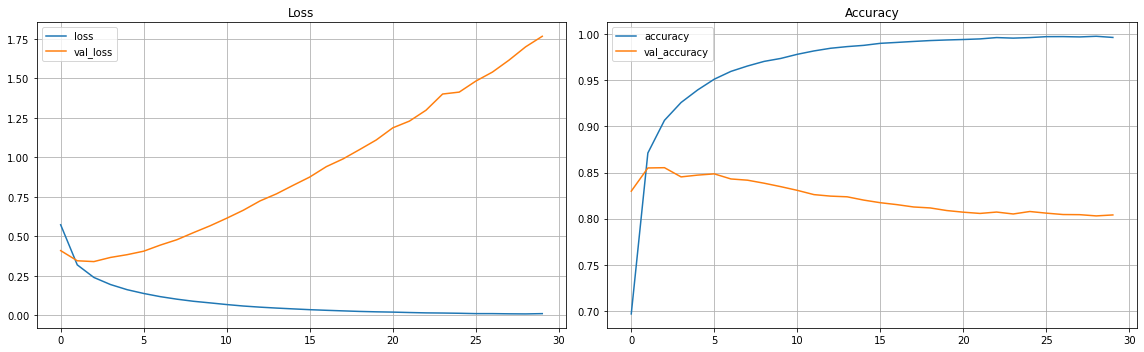

In [24]:
import pandas as pd

history_df = pd.DataFrame(history.history, columns=['loss','accuracy','val_loss','val_accuracy'])
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5))
history_df[['loss','val_loss']].plot(ax=ax1, grid=True, title='Loss')
history_df[['accuracy','val_accuracy']].plot(ax=ax2, grid=True, title='Accuracy')
plt.tight_layout()

We can see accuracy increase nicely as we trained and the validation accuracy was okay, but not great. What's interesting is the loss values on the right, the training loss fall, but the validation loss increased. Well, why might that be?<br>
We can think about loss as the confidence in the prediction. So while the number of accurate predictions increased over time, what was interesting was that the confidence per prediction effectively decreased. You may find this happening a lot with text data. So it's very important to keep an eye on it. One way to do this is to explore the differences as you tweak the hyperparameters.<br>
So for example, if you consider these changes, a decrease in vocabulary size, and taking shorter sentences, reducing the likelihood of padding, and then rerun we can see something different.

In [25]:
vocab_size = 1000 # was 10000
embeddin_dim = 16
max_lenght = 16   # was 32
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'
# total of 27000 records
training_size = 20000
# rerun everything from above but don't clean the plot 

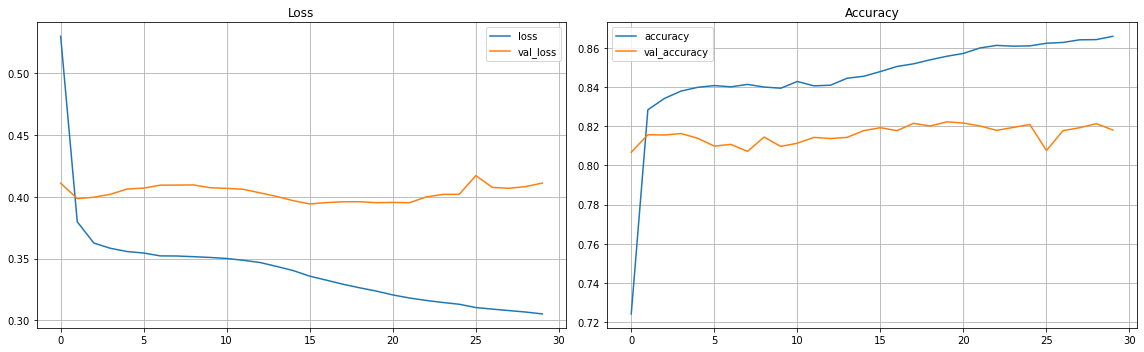

In [30]:
history_df = pd.DataFrame(history.history, columns=['loss','accuracy','val_loss','val_accuracy'])
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5))
history_df[['loss','val_loss']].plot(ax=ax1, grid=True, title='Loss')
history_df[['accuracy','val_accuracy']].plot(ax=ax2, grid=True, title='Accuracy')
plt.tight_layout()

Here, you can see that the loss has flattened out which looks good, but of course, your accuracy is not as high. So a hyperparameters grid search would be usefull.

In [36]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# get the decoded sentence
def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[0])
print(labels[0])

former <OOV> store <OOV> <OOV> over secret <OOV> <OOV> for <OOV> <OOV> ? ? ? ?
former versace store clerk sues over secret 'black code' for minority shoppers
0


Now let's visualize the embedding. Start by getting the results of the embedding layer, which is layer 0, then get the weights. To plot the embedding we need to reverse the word index.<br>
Now it's time to write the vectors and their metadata auto files. The TensorFlow Projector reads this file type and uses it to plot the vectors in 3D space so we can visualize them. To the vectors file, we simply write out the value of each of the items in the array of embeddings, i.e, the co-efficient of each dimension on the vector for this word. To the metadata array, we just write out the words. If you're working in Colab, this code will download the two files. To now render the results, go to the TensorFlow Embedding Projector on projector.tensorflow.org, press the ''Load data'' button on the left. You'll see a dialog asking you to load data from your computer. Use vector.TSV for the first one, and meta.TSV for the second. Once they're loaded, you should see something like this. Click this ''sphereize data'' checkbox on the top left, and you'll see the binary clustering of the data.

In [33]:
import io

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# to create the tensors
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

(1000, 16)


In [40]:
sentence = ["granny starting to fear spiders in the garden might be real",
            "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_lenght,
                       padding=padding_type, truncating=trunc_type)

print(model.predict(padded))

[[0.43771434]
 [0.56423795]]
